In [1]:
import os
import pickle

import numpy as np
import pandas as pd

import operator

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import binom
from scipy.stats import entropy
from scipy.stats import pearsonr

import zarr
import dask.array as da

from utils.utility_functions import (transposeZarr, log_transform, clip_outlier_pixels)

In [2]:
# Paths and input
out = os.path.join(os.getcwd(), 'output/VAE20_ROT_VIG40_entropy_by_VAE9_ROT_VIG18')
if not os.path.exists(out):
    os.makedirs(out)

# Read single-cell sample for VAE analysis
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))

count_headers = [f'VAE9_{i}' for i in sorted(main['VAE9_ROT_VIG18'].unique())]

In [3]:

if not os.path.exists(os.path.join(out, 'counts_minus_ref.csv')):

    counts = pd.DataFrame(columns=['VAE20_ROT_VIG40', 'VAE9_ROT_VIG18'] + count_headers)

    for vae_cluster, group in main.groupby('VAE20_ROT_VIG40'):
        print(vae_cluster)
        for i in group.iterrows():
            dta = pd.DataFrame(columns=['VAE20_ROT_VIG40', 'VAE9_ROT_VIG18'] + count_headers)
            dta.loc[0, 'VAE20_ROT_VIG40'] = vae_cluster
            dta.loc[0, 'VAE9_ROT_VIG18'] = int(i[1]['VAE9_ROT_VIG18'])
            dta.loc[0, count_headers] = 0

            # isolate cells within 30x30 pixel area (20um2)
            x = i[1]['X_centroid']
            y = i[1]['Y_centroid']
            patch = (
                main[(main['Y_centroid'].between(y - 15, y + 15)) &
                    (main['X_centroid'].between(x - 15, x + 15))].copy()
            )

            cnts = patch.groupby('VAE9_ROT_VIG18').size()
            for j in cnts.index:
                dta.loc[0, f'VAE9_{j}'] = cnts[j]
            counts = pd.concat([counts, dta], axis=0)
    
    counts.reset_index(drop=True, inplace=True)
    counts.to_csv(os.path.join(out, 'counts.csv'), index=False)

    # Subtract reference cells from counts table
    for idx, dta in counts.iterrows():
        if idx % 10000 == 0:
            print(idx)
        current = counts.loc[idx, f"VAE9_{dta['VAE9_ROT_VIG18']}"]
        counts.loc[idx, f"VAE9_{dta['VAE9_ROT_VIG18']}"] = (current - 1)
    counts.to_csv(os.path.join(out, 'counts_minus_ref.csv'), index=False)

else:
    # Read reference cell substracted counts table
    counts = pd.read_csv(os.path.join(out, 'counts_minus_ref.csv'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000


In [4]:
# Compute VAE20_ROT_VIG40 cluster enrichment pvals

# scipy.stats.binom.cdf(k, n, p)

# k: float or array_like of floats representing random variable
# (i.e. how many cells of a particular VAE9 cluster are
#  in a given VAE20_ROT_VIG40 cluster's image patches)

# n: number of trials, must be >= 0
# (i.e. how many cells are in a given VAE20_ROT_VIG40 cluster)

# p: probability of success in each trial, must be in range [0, 1]
# (i.e. what is the frequency of a given VAE9 cluster in the dataset)

counts = counts[counts['VAE20_ROT_VIG40'].isin(main['VAE20_ROT_VIG40'].unique())]

ppp = counts.groupby('VAE9_ROT_VIG18').size() / len(counts)
ppp.index = [f'VAE9_{i}' for i in ppp.index]

nnn = counts.groupby(['VAE20_ROT_VIG40']).size()

kkk = counts.loc[:, counts.columns != 'VAE9_ROT_VIG18'].groupby(['VAE20_ROT_VIG40']).sum()

pvals = kkk.copy().astype('float')
for vae_cluster in kkk.index:
    for vae_cluster_w14 in kkk.columns:

        # Plot CDF
        if (vae_cluster == 35) and (vae_cluster_w14 == 'VAE9_0'):
            x = np.arange(0, nnn[vae_cluster], 0.01)
            y = binom.cdf(k=x, n=nnn[vae_cluster], p=ppp[vae_cluster_w14])
            plt.plot(x, y, c='k')
            plt.tight_layout()
            plt.savefig(os.path.join(out, 'V35_cdf.pdf'))
            plt.close('all')

        # Compute pval at specific x-coordinate in CDF
        k = kkk.loc[vae_cluster, vae_cluster_w14]
        pval = 1 - binom.cdf(k=k, n=nnn[vae_cluster], p=ppp[vae_cluster_w14])
        pvals.loc[vae_cluster, vae_cluster_w14] = pval

In [5]:
# Compute Shannon entropy (i.e., VAE9 cluster heterogeneity) for VAE20_ROT_VIG40 clusters
entropies = {}
for vae_cluster, group in main.groupby('VAE20_ROT_VIG40'):
    percents = group.groupby('VAE9_ROT_VIG18').size() / len(group)
    percents_pad = percents.reindex(sorted(main['VAE9_ROT_VIG18'].unique()), fill_value=0.0)
    entropies[vae_cluster] = entropy(pk=percents_pad, base=2)

# Sort entropy scores in ascending order
entropies = dict(sorted(entropies.items(), key=operator.itemgetter(1), reverse=False))

e1 = pd.DataFrame.from_dict(entropies, orient='index')
e1.rename(columns={0: 'entropy'}, inplace=True)

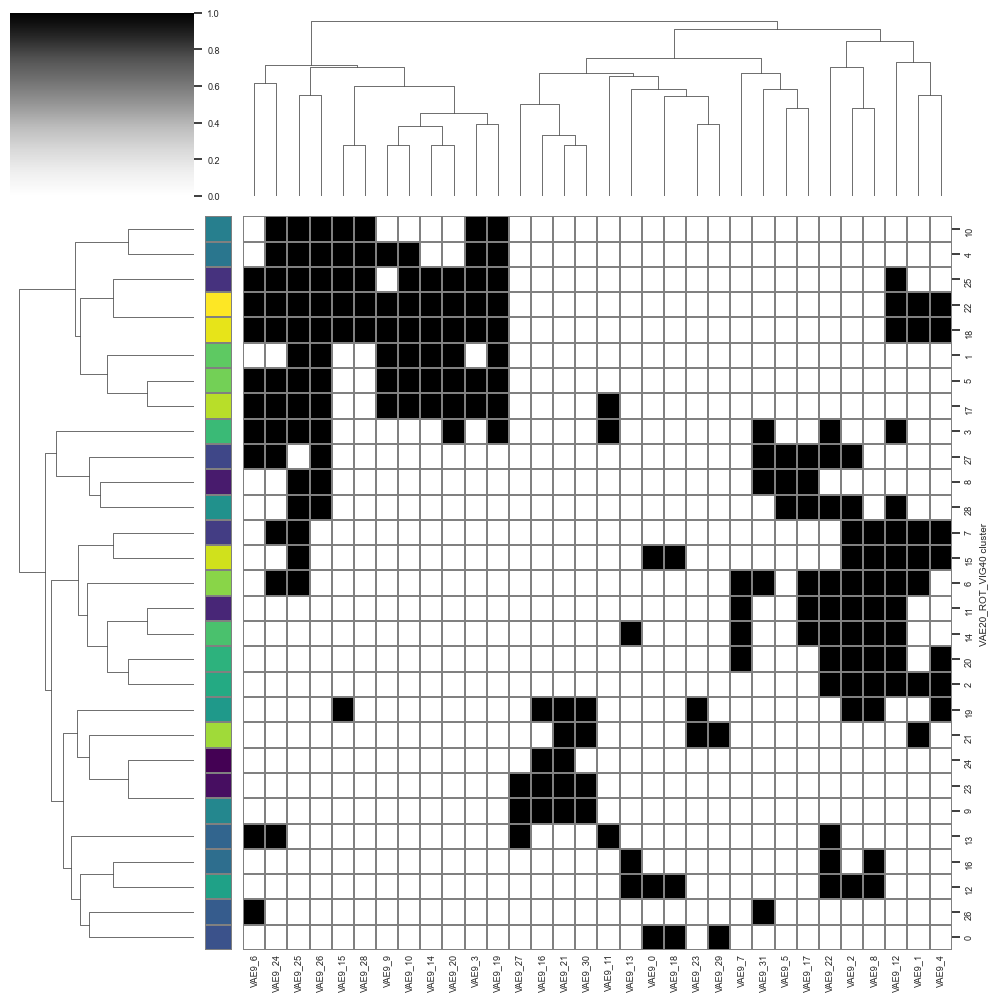

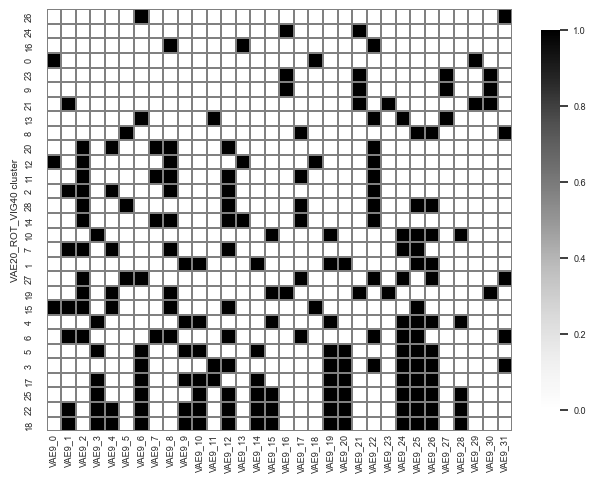

In [6]:
# Plot heatmap of CDF pvals
sns.set(font_scale=0.6)
sns.set_style('white')
heatmap = pvals[pvals <= 0.05]
heatmap = heatmap.notnull().astype('int')

test = heatmap.sum(axis=1)
test2 = main.groupby('VAE20_ROT_VIG40').size()
test3 = test2.reindex(test.index)

test4 = pd.DataFrame(data={'VAE9_count': test, 'size': test3})
test4 = test4.sort_values(['VAE9_count', 'size'])
heatmap = heatmap.reindex(test4.index)

# Divide viridis colors into to the number of VAE clusters
viridis = plt.get_cmap('viridis', heatmap.shape[0])
# Map VAE clusters to their entropy scores
ent = dict(zip(heatmap.index, [entropies[i] for i in heatmap.index]))
# Sort the dict by entropy scores (i.e., values)
ent = {k: v for k, v in sorted(ent.items(), key=lambda item: item[1])}
# Map VAE clusters in heatmap, sorted by entropy, onto viridis colors
lut = dict(zip(ent.keys(), viridis.colors))
# Create colors index
row_colors = heatmap.index.map(lut)

g = sns.clustermap(
    heatmap, xticklabels=1, yticklabels=1, cmap='Greys', linecolor='grey',
    linewidths=0.3, cbar_kws={'shrink': 0.9}, row_colors=row_colors
)
g.ax_heatmap.set_ylabel('VAE20_ROT_VIG40 cluster')
g.ax_heatmap.get_xaxis().set_tick_params(pad=-4)
plt.tight_layout()
plt.savefig(os.path.join(out, 'pvals_clustermap.pdf'))
plt.show()
plt.close('all')

sns.heatmap(
    heatmap, xticklabels=1, yticklabels=1, cmap='Greys', linecolor='grey',
    linewidths=0.3, square=True, cbar_kws={'shrink': 0.9}
)
plt.ylabel('VAE20_ROT_VIG40 cluster')
plt.tick_params(axis='x', which='major', pad=-4)
plt.tight_layout()
plt.savefig(os.path.join(out, 'pvals_heatmap.pdf'))
plt.show()
plt.close('all')

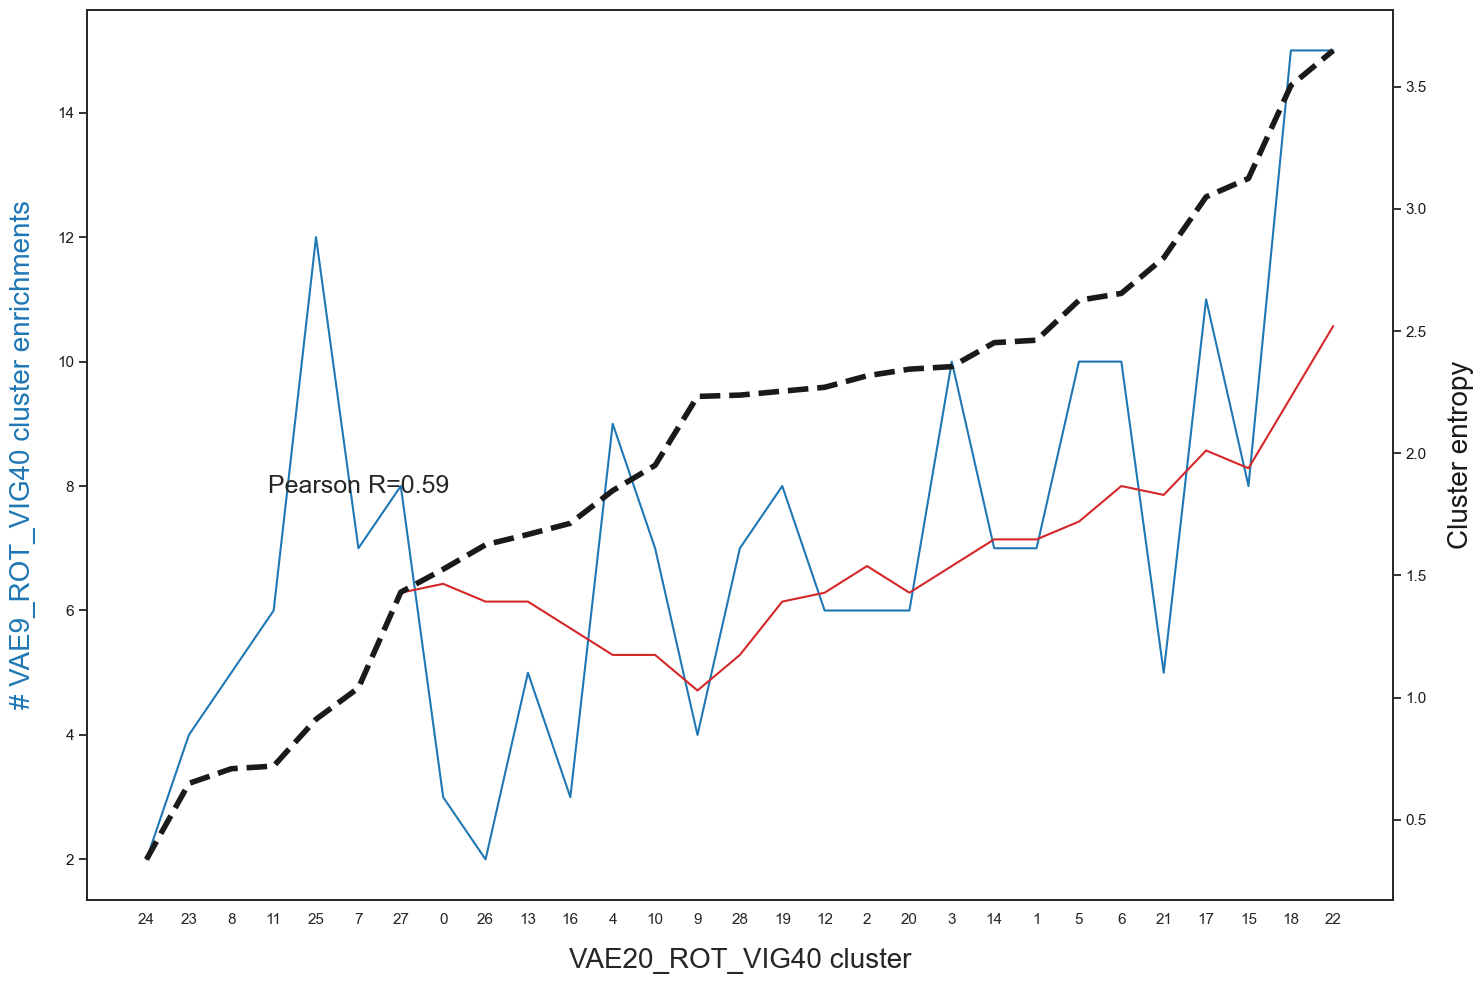

In [7]:
# Plot VAE20_ROT_VIG40 cluster entropy and VAE9 cluster enrichments on shared y-axis
sns.set(font_scale=1.0)
sns.set_style('white')
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()

count_thresholds = heatmap.sum(axis=1).sort_values()
count_thresholds = count_thresholds.reindex(entropies.keys())

e1['VAE9_count'] = count_thresholds

ax1.plot(
    [str(i) for i in count_thresholds.index], count_thresholds.values,
    c='tab:blue', lw=1.5, linestyle='-')

# Plot rolling count threshold average
rolling = count_thresholds.rolling(7).mean()
rolling.dropna(inplace=True)
ax1.plot([str(i) for i in rolling.index], rolling.values, c='tab:red', lw=1.5, linestyle='-')

ax1.set_xlabel('VAE20_ROT_VIG40 cluster', size=20, labelpad=15)
ax1.set_ylabel('# VAE9_ROT_VIG40 cluster enrichments', size=20, labelpad=15, c='tab:blue')
ax1.tick_params(axis='y', colors='k')
ax2.plot([str(i) for i in entropies.keys()], entropies.values(), c='k', lw=4, linestyle='--')
ax2.set_ylabel('Cluster entropy', size=20, labelpad=15, c='k')
ax2.tick_params(axis='y', colors='k')

# Compute Pearson correlation coefficient
stat, pval = pearsonr(
    [i for i in entropies.values()], [i for i in count_thresholds.values], alternative='two-sided'
)
ax1.annotate(
    f'Pearson R={round(stat, 2)}', xy=(5, 8), horizontalalignment='center',
    verticalalignment='center', size=18
)
plt.tight_layout()
fig.savefig(os.path.join(out, 'entropy_vs_VAE9-enrichment.pdf'))
plt.show()
plt.close('all')

In [8]:
# Compute mean aggregate-channel intensities per VAE cluster
root = os.path.join(os.getcwd(), 'input/VAE20_ROT_VIG40')
combo_dir = os.path.join(root, '6_latent_space_LD850/combined_zarr')

# Read percentile cutoffs selected in script 4_feature_preprocessing_selections
with open(
    os.path.join(root, '4_feature_preprocessing_selections/cutoffs.pkl'), 'rb'
    ) as handle:
    cutoffs = pickle.load(handle)

# Read combined training, validation, and test thumbnails, load into memory
X_combo = zarr.open(combo_dir)
X = transposeZarr(z=X_combo)  # X is now a dask array
X = X[main.index, :, :, :]

# Log-transform and clip outliers of image patch sample
X = clip_outlier_pixels(log_transform(X), cutoffs)

mean_signals = pd.DataFrame(columns=['mean', 'std', 'q25', 'q50', 'q75', 'VAE20_ROT_VIG40'])

means = X.sum(axis=3).mean(axis=(1, 2)).compute()
stds = X.sum(axis=3).std(axis=(1, 2)).compute()

q25, q50, q75 = np.percentile(
    X.sum(axis=3).reshape(X.sum(axis=3).shape[0], -1).compute(), [25, 50, 75], axis=1
)

# Normalize pixels 0-1
# img = ((img - np.min(img)) / (np.max(img) - np.min(img)).astype('float32'))

mean_signals['VAE20_ROT_VIG40'] = main['VAE20_ROT_VIG40']
mean_signals['mean'] = means
mean_signals['std'] = stds
mean_signals['q25'] = q25
mean_signals['q50'] = q50
mean_signals['q75'] = q75

# Drop unclustered cells before plotting clustermap
mean_signals = mean_signals.groupby('VAE20_ROT_VIG40').mean()

e1['mean'] = mean_signals['mean']
e1['std'] = mean_signals['std']
e1['q25'] = mean_signals['q25']
e1['q50'] = mean_signals['q50']
e1['q75'] = mean_signals['q75']

e1.to_csv(os.path.join(out, 'regression_variables.csv'))

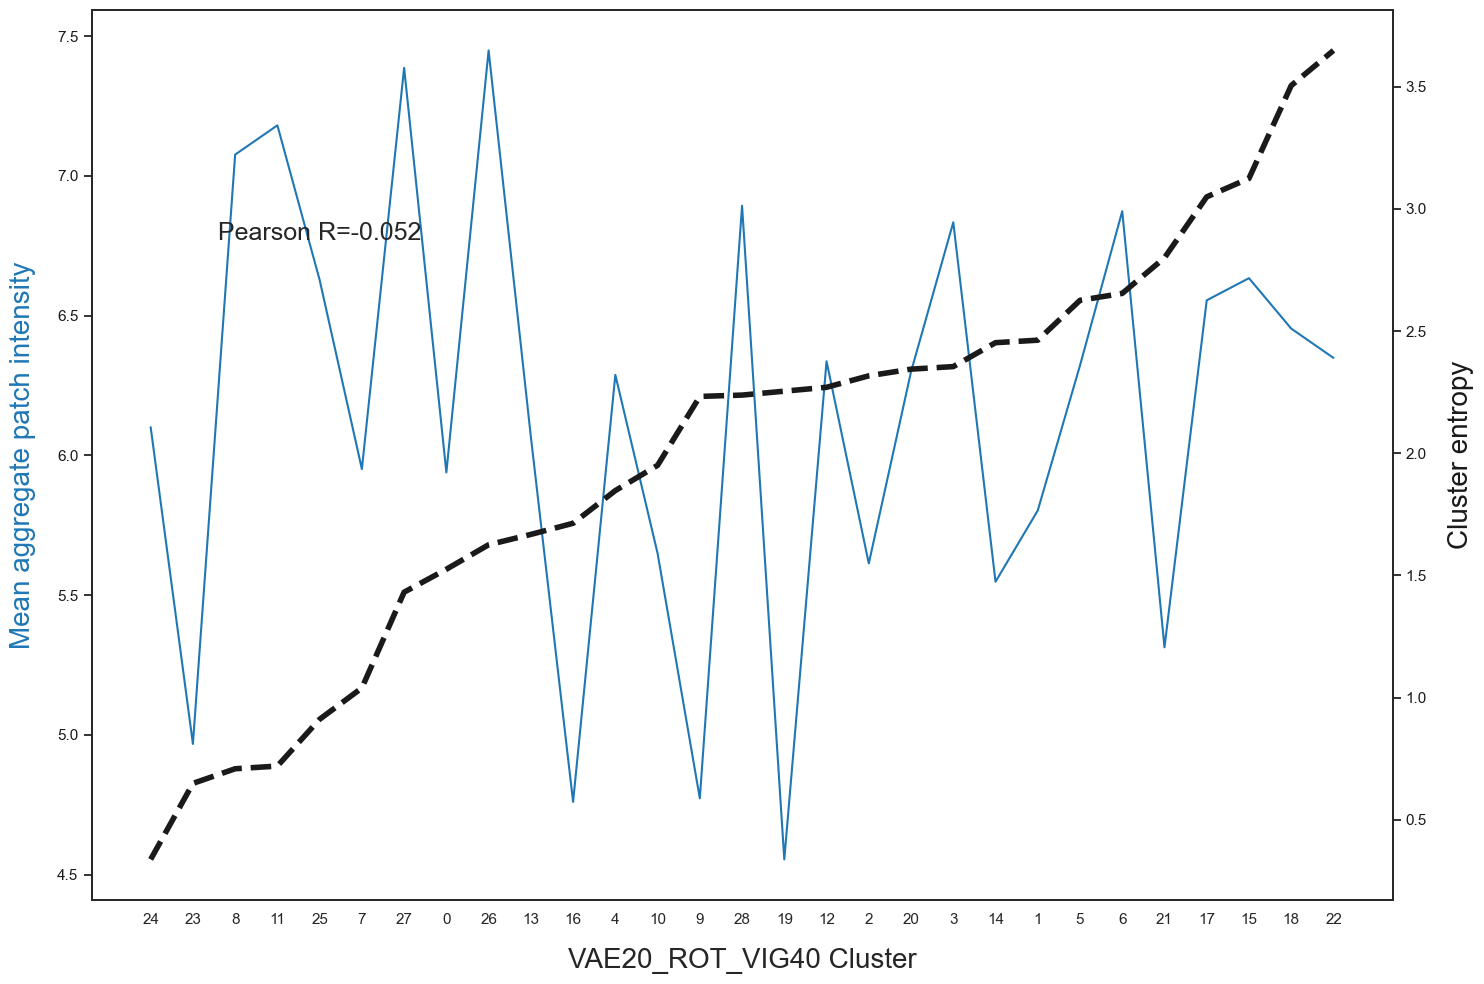

In [9]:
# Plot VAE20_ROT_VIG40 cluster entropy and mean aggregate patch intensity on shared y-axis
mean_signals = mean_signals.reindex(entropies.keys())

sns.set(font_scale=1.0)
sns.set_style('white')
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()
ax1.plot(
    [str(i) for i in mean_signals.index], mean_signals['mean'], c='tab:blue', lw=1.5, linestyle='-'
)
ax1.set_xlabel('VAE20_ROT_VIG40 Cluster', size=20, labelpad=15)
ax1.set_ylabel('Mean aggregate patch intensity', size=20, labelpad=15, c='tab:blue')
ax1.tick_params(axis='y', colors='k')
ax2.plot([str(i) for i in entropies.keys()], entropies.values(), c='k', lw=4, linestyle='--')
ax2.set_ylabel('Cluster entropy', size=20, labelpad=15, c='k')
ax2.tick_params(axis='y', colors='k')

# Compute Pearson correlation coefficient
stat, pval = pearsonr(
    [i for i in entropies.values()], [i for i in mean_signals['mean'].values],
    alternative='two-sided'
)
ax2.annotate(
    f'Pearson R={round(stat, 3)}', xy=(4.0, 2.9),
    horizontalalignment='center', verticalalignment='center', size=18
)
plt.tight_layout()
fig.savefig(os.path.join(out, 'entropy_vs_mean-agg-signals.pdf'))
plt.show()
plt.close('all')

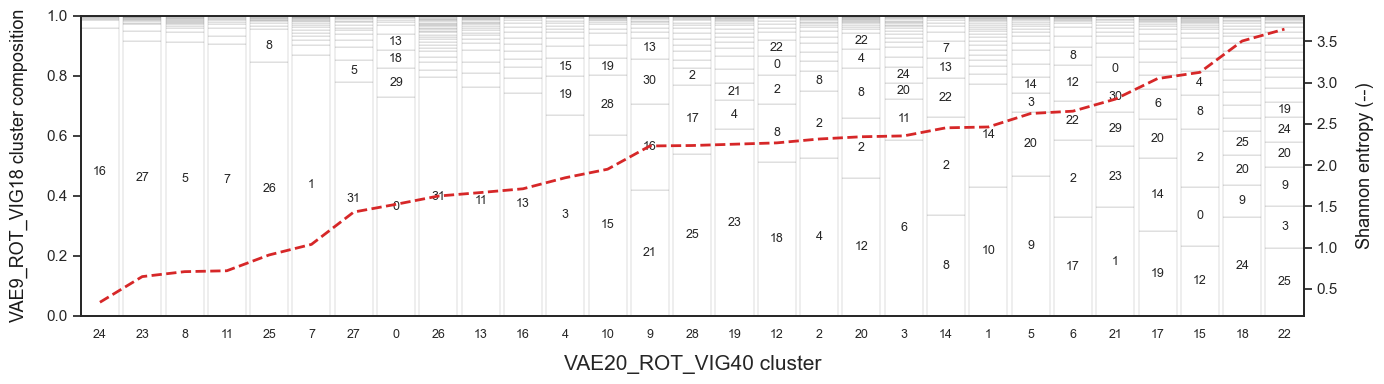

In [11]:
# Plot stacked barcharts
bar = main.groupby(['VAE20_ROT_VIG40', 'VAE9_ROT_VIG18']).size().unstack().fillna(0)
# bar.drop(columns=[-1], inplace=True)

# Normalize VAE9 counts per VAE20_ROT_VIG40 cluster (0-1), sort VAE clusters by entropy
bar = bar.div(bar.sum(axis=1), axis=0)
bar = bar.reindex(entropies.keys())
bar.columns = bar.columns.astype('str')

vals = bar.values.copy()
vals.sort(axis=1)
pbar = pd.DataFrame(index=bar.index, columns=bar.columns, data=vals)
pbar.plot.bar(stacked=True, lw=0.0, legend=False, width=1.0, colormap='tab20')
plt.tight_layout()
plt.savefig(os.path.join(out, 'stacked_bar.pdf'))
plt.close('all')

fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()
x = bar.index.astype('str')
indexes = np.argsort(bar.values).T
heights = np.sort(bar.values).T
order = -1
bottoms = heights[::order].cumsum(axis=0)
bottoms = np.insert(bottoms, 0, np.zeros(len(bottoms[0])), axis=0)

for btms, (idxs, vals) in enumerate(list(zip(indexes, heights))[::order]):

    mps = np.take(np.array(bar.columns), idxs)
    g = ax1.bar(
        x, height=vals, width=0.9, color='w', lw=0.1, ec='k',
        bottom=bottoms[btms]
        )

    pos = -1
    for i, b in enumerate(g.patches):
        if i % len(bar.index) == 0:
            pos += 1
        xloc = b.get_x() + 0.45
        yloc = b.get_y() + b.get_height()/2
        if b.get_height() > 0.05:
            ax1.annotate(
                mps[i], xy=(xloc, yloc), fontname='Arial',
                va='center', ha='center', size=9
                )

ax1.set_xlabel('VAE20_ROT_VIG40 cluster', size=15, labelpad=10)
ax1.set_ylabel('VAE9_ROT_VIG18 cluster composition', size=13, labelpad=13, c='k')
ax1.tick_params(axis='x', which='major', labelsize=9)
ax1.margins(x=0)

ax2.plot(
    [str(i) for i in entropies.keys()], entropies.values(),
    c='tab:red', lw=2, linestyle='--'
    )
ax2.set_ylabel('Shannon entropy (--)', size=13, labelpad=13, c='k')

plt.tight_layout()
plt.savefig(os.path.join(out, 'stacked_bar_new.pdf'))
plt.show()
plt.close('all')